# Motion Correction Tutorial

This Jupyter Notebook presents an example of the application of motion correction in T1 and DWI MRI images.


The motion correction algorithm uses Model-Driven Registration (MDR). `ukat` calls the python package `mdr_library` and its source code can be found at: https://github.com/QIB-Sheffield/MDR_Library


Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import nibabel as nib
from dipy.io import read_bvals_bvecs
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.utils.tools import convert_to_pi_range
from ukat.mapping.t1 import T1, magnitude_correct
from ukat.mapping.diffusion import ADC, DTI
from ukat.moco.mdr import MotionCorrection
from MDR.Tools import export_animation

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
base_path = "C:\\Users\\md1jgra\\Desktop\\UKRIN-MDR-Analysis\\EDI_sub5_T1_DWI"
OUTPUT_DIR_T1 = os.path.join(base_path, "T1 Results")
OUTPUT_DIR_DWI = os.path.join(base_path, "DWI Results")

Fetch T1 test data

In [2]:
image_file = os.path.join(base_path, "00065__T1_mapping_(SE-EPI).nii.gz")
magnitude = nib.load(image_file).get_fdata()
print(np.shape(magnitude))
# Either
magnitude_corrected = magnitude
# Or
#phase = convert_to_pi_range(phase)
#complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase)) # convert magnitude and phase into complex data
#magnitude_corrected = np.squeeze(magnitude_correct(complex_data))
affine_t1 = nib.load(image_file).affine
ti = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]) # in ms
tss = 58 # in ms
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_t1 = [affine_t1, ti, tss, None, None, 3, False]

(128, 128, 5, 15)


Fetch DWI test data

In [3]:
image_file = os.path.join(base_path, "00024__DWI.nii.gz")
bvals_file = os.path.join(base_path, "00024__DWI.bval")
bvecs_file = os.path.join(base_path, "00024__DWI.bvec")
pixel_array = nib.load(image_file).get_fdata()
affine_dwi = nib.load(image_file).affine
bvals, bvecs = read_bvals_bvecs(bvals_file, bvecs_file)
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_dwi = [affine_dwi, bvals, None, True]

Set masks for motion correction

In [4]:
mask_flag = True

if mask_flag == True:
    x_t1 = np.shape(magnitude_corrected)[0]
    y_t1 = np.shape(magnitude_corrected)[1]
    x_dwi = np.shape(pixel_array)[0]
    y_dwi = np.shape(pixel_array)[1]
    mask_moco_t1 = np.ones(np.shape(magnitude_corrected))
    mask_moco_dwi = np.ones(np.shape(pixel_array))
    mask_moco_t1[:int(x_t1/6), ...] = 0
    mask_moco_t1[int(5*x_t1/6):, ...] = 0
    mask_moco_t1[:, :int(y_t1/6), ...] = 0
    mask_moco_t1[:, int(5*y_t1/6):, ...] = 0
    mask_moco_dwi[:int(x_dwi/6), ...] = 0
    mask_moco_dwi[int(5*x_dwi/6):, ...] = 0
    mask_moco_dwi[:, :int(y_dwi/6), ...] = 0
    mask_moco_dwi[:, int(5*y_dwi/6):, ...] = 0
    mask_t1_model = np.array(mask_moco_t1[..., 3], dtype=bool)
    mask_dwi_model = np.array(mask_moco_dwi[..., 3, 0], dtype=bool)
else:
    mask_moco_t1 = None
    mask_moco_dwi = None

## T1 Model-Driven Registration

In [5]:
t1_registration = MotionCorrection(magnitude_corrected, affine_t1, 'T1_Moco', list_input_parameters_t1, convergence=1, multithread=False, log=False, mask=mask_moco_t1)

100%|██████████| 16384/16384 [02:23<00:00, 114.11it/s]
divide by zero encountered in true_divide
Co-registration progress: 100%|██████████| 15/15 [00:41<00:00,  2.78s/it]


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


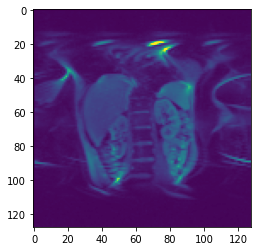

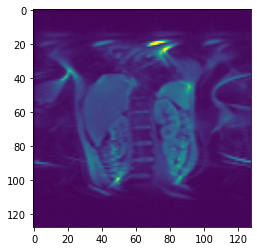

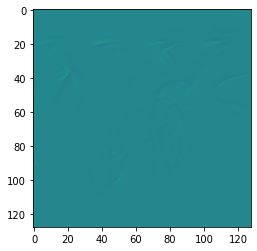

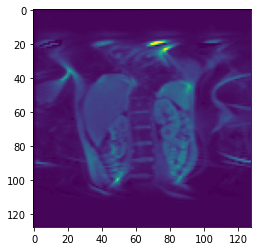

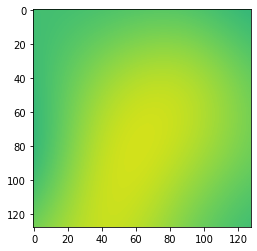

In [6]:
# Get the T1 coregistered pixel_array and the array with the difference between the original and the motion corrected
t1_moco_array = t1_registration.get_coregistered()
t1_moco_diff_array = t1_registration.get_diff_orig_coreg()
# Save motion corrected T1 sequence to NIfTI
t1_registration.to_nifti(output_directory=OUTPUT_DIR_T1, base_file_name='T1_motion_corrected', maps=['original', 'coregistered', 'difference', 'fitted', 'mask', 'deformation_field', 'parameters'])
t1_registration.to_gif(output_directory=OUTPUT_DIR_T1, base_file_name='T1_motion_corrected', maps=['original', 'coregistered', 'difference', 'fitted', 'deformation_field'])

In [11]:
# Calculate maps from the original T1 sequence save as niftis
t1_mapper = T1(magnitude_corrected, ti, affine=affine_t1, multithread=False, parameters=3, tss=tss)
t1_mapper.to_nifti(output_directory=OUTPUT_DIR_T1, base_file_name='T1_original', maps='all')
t1_map = np.rot90(t1_mapper.t1_map)
export_animation(t1_map, OUTPUT_DIR_T1, 'T1_original_t1_map')

# Calculate maps from the motion corrected T1 sequence and save as niftis
t1_moco_mapper = T1(t1_moco_array, ti, affine=affine_t1, multithread=False, parameters=3, tss=tss)
t1_moco_mapper.to_nifti(output_directory=OUTPUT_DIR_T1, base_file_name='T1_moco', maps='all')
t1_map_moco = np.rot90(t1_moco_mapper.t1_map)
export_animation(t1_map_moco, OUTPUT_DIR_T1, 'T1_moco_t1_map')

# Calculate maps from the motion corrected T1 sequence with 14 TIs (to match with GOSH Siemens scans) and save as niftis
ti_14 = np.array([200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]) # in ms
t1_14_tis = np.stack([t1_moco_array[..., index] for index, t in enumerate(ti_14)], axis=-1)
t1_14_tis_mapper = T1(t1_14_tis, ti_14, affine=affine_t1, multithread=False, parameters=3, tss=tss)
t1_14_tis_mapper.to_nifti(output_directory=OUTPUT_DIR_T1, base_file_name='T1_14tis', maps='all')
t1_map_14_tis = np.rot90(t1_14_tis_mapper.t1_map)
export_animation(t1_map_14_tis, OUTPUT_DIR_T1, 'T1_14tis_t1_map')

  1%|          | 576/81920 [00:08<20:40, 65.56it/s]

Plot difference

Plot maps

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Display the T1 map generated from the original data
im = ax1.imshow(np.rot90(t1_mapper.t1_map), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1 Original$ (ms)')
ax1.axis('off')

# Display the T1 map generated from the motion corrected data
im2 = ax2.imshow(np.rot90(t1_moco_mapper.t1_map), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('$T_1 Moco$ (ms)')
ax2.axis('off')

plt.show()

## DWI Model-driven registration

In [8]:
dwi_registration = MotionCorrection(pixel_array, affine_dwi, 'DWI_Moco', list_input_parameters_dwi, convergence=1, multithread=False, log=False, mask=mask_moco_dwi)

Co-registration progress: 100%|██████████| 79/79 [03:29<00:00,  2.65s/it]


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


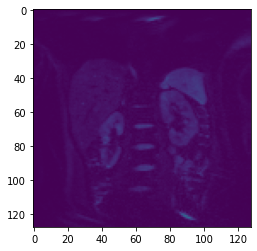

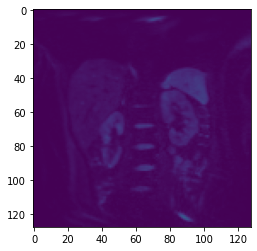

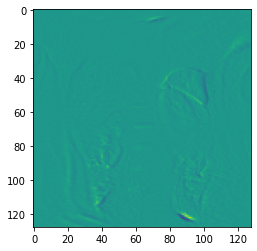

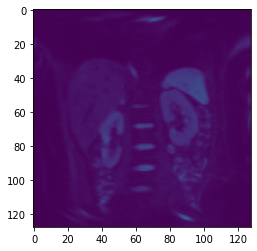

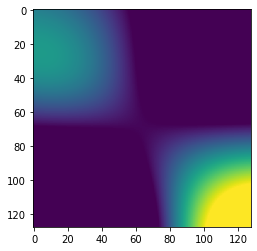

In [9]:
# Get the DWI coregistered pixel_array and the array with the difference between the original and the motion corrected
dwi_moco_array = dwi_registration.get_coregistered()
dwi_moco_diff_array = dwi_registration.get_diff_orig_coreg()
# Save motion corrected diffusion sequence to NIfTI
dwi_registration.to_nifti(output_directory=OUTPUT_DIR_DWI, base_file_name='DWI_motion_corrected', maps=['original', 'coregistered', 'difference', 'mask', 'fitted', 'deformation_field', 'parameters'])
dwi_registration.to_gif(output_directory=OUTPUT_DIR_DWI, base_file_name='DWI_motion_corrected', maps=['original', 'coregistered', 'difference', 'fitted', 'deformation_field'])

100%|██████████| 103394/103394 [00:22<00:00, 4649.31it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.
100%|██████████| 177897/177897 [00:38<00:00, 4649.71it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


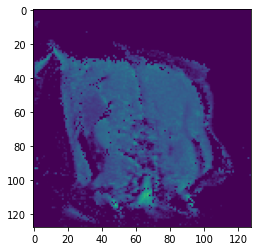

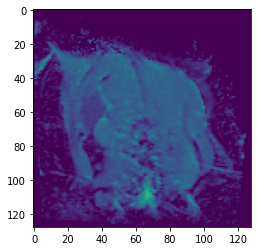

In [10]:
# Calculate maps from the original diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine_dwi, bvals, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR_DWI, base_file_name='diffusion_original', maps='all')
adc_map = np.rot90(adc_mapper.adc)
export_animation(adc_map, OUTPUT_DIR_DWI, 'DWI_original_adc_map')

# Calculate maps from the original diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine_dwi, bvals, bvecs, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR_DWI, base_file_name='diffusion_original', maps=['md', 'fa'])

# Calculate maps from the motion corrected diffusion sequence using ADC methods and save as niftis
adc_mapper_moco = ADC(dwi_moco_array, affine_dwi, bvals, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR_DWI, base_file_name='diffusion_moco', maps='all')
adc_map_moco = np.rot90(adc_mapper_moco.adc)
export_animation(adc_map_moco, OUTPUT_DIR_DWI, 'DWI_moco_adc_map')

# Calculate maps from the motion corrected diffusion sequence using DTI methods and save as niftis
dti_mapper_moco = DTI(dwi_moco_array, affine_dwi, bvals, bvecs, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR_DWI, base_file_name='diffusion_moco', maps=['md', 'fa'])

Plot differences

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Display the T1 map generated from the original data
im = ax1.imshow(np.rot90(pixel_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('DWI Original')
ax1.axis('off')

# Display the T1 map generated from the motion corrected data
im2 = ax2.imshow(np.rot90(dwi_moco_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('DWI Moco')
ax2.axis('off')

# Display the T1 map generated from the motion corrected data
im3 = ax3.imshow(np.rot90(dwi_moco_diff_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im3, ax=ax3)
cb.set_label('DWI Moco Difference')
ax3.axis('off')

plt.show()

Plot maps

In [ ]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')

In [ ]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper_moco.adc[:, :, adc_mapper_moco.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper_moco.md[:, :, dti_mapper_moco.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper_moco.fa[:, :, dti_mapper_moco.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper_moco.color_fa[:, :, dti_mapper_moco.shape[2]//2, :]))
ax[1, 1].axis('off')